### ID3 Implemented from scratch with python
** some basic pandas and nupmpy utility functions are used

### Utility functions

Here I tried to avoid pandas utility functions and implemented many of them from scracth.

1. get_possible_labels
2. get_target_label_count
3. get_most_common
4. get_df_with_label

In [1]:
import pandas as pd
import sys
import numpy as np
import csv
from copy import deepcopy
from matplotlib import pyplot as plt
sys.__stdout__=sys.stdout
use_pandas=True

def get_attr_names(df):
    return list(df.columns.values)

def get_possible_labels(examples,attr_name):     #getting possible labels of a attribute
    if use_pandas==False:
        attr_column=examples[attr_name]
        labels=[]
        for m in attr_column:
            if m not in labels:
                labels.append(m)
        return(labels)
    else :
        return examples[attr_name].unique()

def get_target_label_counts(target_attr,target_labels): #getting target label counts of a dataset
    if use_pandas==False:
        counts={}
        for label in target_labels:
            counts[label]=0
        for j in target_attr.index:
                target_val=target_attr[j]
                for label in target_labels:
                    if target_val==label:
                        counts[label]=counts[label]+1
        return counts
    else:
        return dict(target_attr.value_counts())
    
def get_most_common(counts):
    #if use_pandas == False:
        counts
        most_common=''
        max_count=0
        for kk,vv in counts.items():
            if int(vv)>max_count:
                   most_common=kk
                   max_count=vv
        return most_common
    
        
    
def get_df_with_label(examples,target_attr,attr_name,label):                        
    
    if use_pandas==False:
        attr_attr=examples.loc[:,attr_name]                                  
        ret=[]
        for index in attr_attr.index:
            if attr_attr[index]!=label:
                ret.append(index)
        examplesVi=examples.drop(ret,axis=0)
        target_attrVi=target_attr.drop(ret)
        
    else :
        _df=deepcopy(examples)
        _df['target']=deepcopy(target_attr)
        gp=_df.groupby(attr_name)
        _df=gp.get_group(label)
        target_attrVi=_df['target']
        examplesVi=_df.drop('target',axis=1)
    return examplesVi,target_attrVi


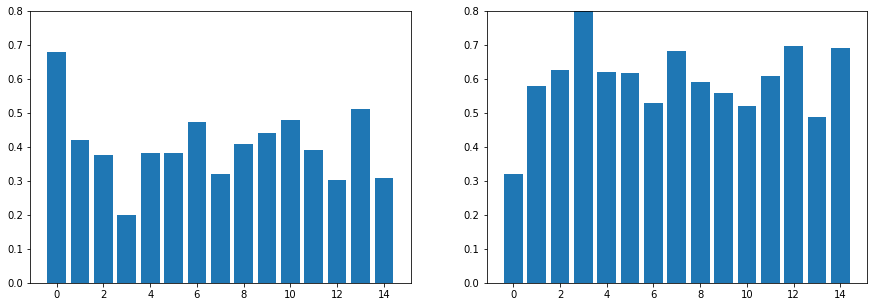

[ 0.42  7.   16.   19.   21.   23.   25.   27.   29.   31.8  34.   37.
 41.   47.   54.   80.  ]


In [2]:
df=pd.read_csv('Dataset/titanic.csv')
nbin=15
Age,bins=pd.qcut(df.Age,nbin,labels=range(1,nbin+1),retbins=True)
label=df.Survived
#Age[label==1]
ydf=Age[label==1].value_counts()
ndf=Age[label==0].value_counts()

_ydf=ydf/(ydf+ndf)
_ndf=ndf/(ydf+ndf)
fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(15,5))
axes[0].set_ylim(0,0.8)
axes[0].bar(range(len(_ydf)),_ydf)
#plt.show()
axes[1].set_ylim(0,0.8)
axes[1].bar(range(len(_ndf)),_ndf)
plt.show()
print(bins)
#plt.bar(range(len(_ydf)),abs(_ydf-_ndf))
#plt.show()

### Data discretization block

1. Entropy based discretization. (Here I have implemented this)
2. Quantile based discretization.

I will try both in thios project.

Below I tried to implement entropy or information gain based discretization.

1. get_thersholds
2. best_split_by_info_gain
3. relabel attributes
4. Discretize

In [3]:
def get_thrsholds(df,attr_name,target_attr):
        df[target_name]=target_attr
        sorted_df=df.sort_values(attr_name,axis=0).reset_index(drop=False)               #Sorting value
        old_index=sorted_df.index.values
        sorted_target=sorted_df[target_name].values
        
        prev_values=sorted_target[0:2] #saving first value as previous value
        thrs_val=[]
        #import pdb;pdb.set_trace()
        for index in range(2,len(sorted_target)):
                 
            curr_val=sorted_target[index]
            prev_values=sorted_target[index-2:index]                                                             #saving values until any change in labels
            if curr_val not in prev_values: 
                val=df.loc[old_index[index],attr_name]                           #getting value of the threshold point 
                if val not in(thrs_val):                              #checking duplicate
                    thrs_val.append(val)                                
                

        #print(attr_name,thrs_val)
        return thrs_val                                       #returning threshold values and index
                
        #df get_splitted_gain


def best_split_by_info_gain(df,attr_name,target_attr,thrs_val):
        max_gain=0;best_thr=0
        
        tg_label_count=get_target_label_counts(target_attr,target_labels)   #getting target labels count
        total_items=(len(df))
        ent_s=entropy(tg_label_count)
        
        for val in thrs_val:                                                ####iteration over each threshold value
            left_ind=df[attr_name]>=val                                     ####spliting for a threshold value                                                                       
            right_ind=df[attr_name]<val
            df_left=df[left_ind]
            df_right=df[right_ind]
            df_list=[df_left,df_right]
            wg_ent_sum=0
            
            for sub_df in df_list:                                          #ierating over splited df
                target_attrVi=sub_df[target_name]
                tg_label_count=get_target_label_counts(target_attrVi,target_labels)
                ent=entropy(tg_label_count)
                no_items=len(target_attrVi)
                wg_ent_sum+=(no_items/total_items)*ent                      ####Getting weighted sum for splited data
            #print(ent_s,wg_ent_sum)
            gain=ent_s-wg_ent_sum                                           ####Getting gain
            if gain>max_gain:
                max_gain=gain
                best_thr=val                                                ####Getting thresh value with max gain
            #print(gain,val,best_thr)
        return best_thr
        
def relabel_attr(df,attr_name,best_thr):                                    
    new_df=deepcopy(df)
    new_df[df[attr_name]>=best_thr]= attr_name+'>='+str(best_thr)                         #Labeling values greater than threshold with descriptive string
    new_df[df[attr_name]<best_thr]= attr_name+'<'+str(best_thr)
        
    return new_df

def discretize(df,attr_names,target_attr):
    new_df=df.copy()
    max_label=25
    for attr_name in attr_names:
        lb=get_possible_labels(df,attr_name)
        if(len(lb)>max_label) and df.dtypes[attr_name] !='object':
            #print(attr_name)
            thrs_val=get_thrsholds(df,attr_name,target_attr)
            best_thr=best_split_by_info_gain(df,attr_name,target_attr,thrs_val)
            new_attr=relabel_attr(df,attr_name,best_thr)
            new_df[attr_name]=new_attr
        else:
            labels=get_possible_labels(df,attr_name)
            lb_num=len(labels)
            if lb_num<=max_label:
                new_df[attr_name]=df[attr_name]
    
    return new_df

### ID3 Funtions
1. Entropy
    
        entropy = -a*log2(a)  -b*log2(b) 
     

2. Gain

        Gain wrt attribute A:
             group the target column by the classes of attribute A. Suppose A have classes a,b,c
        
        gain = entopy_total_dataset - ( entropy(split_a) + entropy(split_b) + entropy(split_c) )
        
        ** here entropy for the targtet column only is needed for gain calculation.


3. ID3
      
      
       1. Enter the ID3 function.
       2. Find the attribute with max information gain.
       3. For label in labels of best attribute :
                             4. get the subset of dataset with label 
                             5. check
4. build tree
5. predict

In [4]:
def entropy(counts):
    total=0
    ent=0
    counts=list(counts.values())
    total=np.sum(counts)
    if total==0:
        return ent
    for val in counts:
        p=val/total
        if p!=0:
            ent-=1*p*np.log2(p)
    return ent

def gain(examples,attr_name,target_attr,target_labels):

    tg_label_count=get_target_label_counts(target_attr,target_labels)            #Getting label(+/-/others) count for dataset/subset
    ent_s=entropy(tg_label_count)                                                #Getting entropy for the dataset/subset
    total_items=len(examples)                                                      #getting total items count in attrumn(attribute)
    gain=0
    split_info=0
    labels=get_possible_labels(examples,attr_name)                                  #Getting possible labels for the attribute
    for i in range(len(labels)):
        _,target_attrVi=get_df_with_label(examples,target_attr,attr_name,labels[i]) #extract subset with label given
        tg_label_count=get_target_label_counts(target_attrVi,target_labels)         #Getting label(+/-/others) count for dataset/subset                                                                    #Running iteration over splitted labels

        ent=entropy(tg_label_count)                                                 #Getting entropy of each split
        no_of_items=len(target_attrVi)                                                 #weighted sum of entropies of splits
        ratio=no_of_items/total_items
        gain=gain+ent*(ratio)

        
        if ratio!=0:
            split_info-=(ratio*np.log2(ratio))                           #Getting weighted sum of split info
            
    gain=ent_s-gain                                                                #Getting information gain               
    if split_info!=0:
        gain_ratio=gain/split_info                                          
    #print('Log ....',attr_name,ent_s,gain)
    return split_info,gain





def ID3(examples,target_attr,attr_names):
    global summary,res,most_common
    
    tg_label_count=get_target_label_counts(target_attr,target_labels)              ###Getting target label counts
    tg_labels=list(tg_label_count.keys())
    most_common=get_most_common(tg_label_count)
    
    if len(tg_labels)==1:
           return tg_labels[0]
    
    
   
    max_gain=-1                                                                     ###Getting attribute with highest gain
    attr_name=''
    for i in range(len(attr_names)):                                                 
        _,gain_value= gain(examples,attr_names[i],target_attr,target_labels)
        if gain_value>max_gain:
            max_gain=gain_value
            attr_name=attr_names[i]
    #print('attr_name',attr_name)
    labels=get_possible_labels(examples,attr_name)                                      ###Getting possible labels for bes attribute
    #print('labels',labels)
    for label in labels:
        examplesVi,target_attrVi=get_df_with_label(examples,target_attr,attr_name,label)###Getting new subset of dataset
        examplesVi=examplesVi.drop(attr_name,axis=1)                            
        res.append(attr_name)                                                           ###returning attr_name,label pair
        res.append(label)
        attr_names=get_attr_names(examplesVi)
        if len(attr_names)==0:# len(target_attrVi)>=2:                                    ###Checking for empty datasets                                                                                         #Getting most common label
            return most_common
        else:
            ret=ID3(examplesVi,target_attrVi,attr_names)                                ###Calling ID3
            if ret !=None:
                res.append(target_name)
                res.append(ret)
                summary.append(res)
                res=[]
    return 


#print('ret',summary)



In [5]:
def build_tree(summary):
    root=summary[0][0]
    for k in range(len(summary)):
        if summary[k][0]==root:
            temp=summary[k]
        if summary[k][0]!=root:
            #print(temp)
            for t in range(len(temp)):
                if temp[t]==summary[k][0]:
                    temp=temp[:t]
                    break
            summary[k]=temp+summary[k]
        #print(summary[k])
def predict(test_sample,summary):
    #import pdb;pdb.set_trace();
    for i in range(len(summary)):
            m=len(summary[i])                      #Taking a rule
            for j in range(m//2):
                attr=summary[i][2*j]               #Taking a attr
                label=summary[i][2*j+1]            #Taking corresponding label
                
                if attr!=target_name:               #last node is not reached
                   if test_sample[attr] != label:   #Checking up to this node test sample is following the rule or not ?
                        pred_label=summary[i][-1]  
                        break
                else :                              # Last Node break
                    pred_label=label
                    break
                        
                                                   #if not break and go for next rule
            if attr == target_name:                #if test data satisfy have all the attr>> label in rule
                pred_label=label
                break                              #setting result according to rule
    return pred_label,i


def predict_all(test_samples,true_labels,summary,verbose=True):
    result_log={'right' : [],'wrong' : [],'Predictions' : [],'True Label' : []}
    acc=0
    wrong=0
    if verbose==True:
        print('--------------------------------')
        print(len(test_samples))
    for kk in range(len(test_samples)):
        test_sample=test_samples.loc[kk,:]
        pred_label,rule_id=predict(test_sample,summary)
        true_label=true_labels[kk]
        if true_label==pred_label:        #Checking results validity from true label
                acc=acc+1
                tp[pred_label]+=1
                #break
        else: wrong+=1
        if true_label!=pred_label:
                 tn[pred_label]+=1
                 fp[true_label]+=1  
        result_log['right'].append(acc)
        result_log['wrong'].append(wrong)
        result_log['Predictions'].append(pred_label)
        result_log['True Label'].append(true_label)
        
        
    accuracy=acc/len(test_df)*100
    
    for label in target_labels:
            try:recall[label]=tp[label]/(tp[label]+tn[label])
            except:0
            try:precision[label]=tp[label]/(tp[label]+fp[label])
            except:0
            if verbose==True:
                print(label,'precision',precision[label],'recall',recall[label])
    
    if verbose==True: print('Summary : ','correct:',acc, 'total :',len(test_df),'accuracy :',acc/len(test_df)*100,'%')
    return accuracy,pd.DataFrame(result_log)

### Main Loop

In [6]:
#df=pd.read_csv('Dataset/iris.csv',delimiter=',' )#,names=names)
df=pd.read_csv('Dataset/titanic.csv',delimiter=',' )#,names=names)
df=df.drop(['Ticket','Cabin'],axis=1)

#df=df.sample(frac=1).reset_index(drop=True)
df=df.fillna(df.mean())
df=df.replace(np.NaN,'nan')

summary=[]
res=[]
attr_names=get_attr_names(df)
target_name='Survived'#attr_names[-1]
target_attr=df[target_name]
target_labels=get_possible_labels(df,target_name)
df=df.drop(target_name,axis=1)
tind=attr_names.index(target_name)
attr_names=attr_names[:tind]+attr_names[tind+1:]

info_gain_discretize=True
quantile_discretize=False

if info_gain_discretize:
    df=discretize(df,attr_names,target_attr)
if quantile_discretize:
    for attr in attr_names:
        if df[attr].dtype!=object:
            temp=pd.qcut(df[attr],4,duplicates="drop")
            df[attr]=temp
            
            

print(attr_names,target_labels)
print(df.head(5))
#input('Press Enter to continue:')


split=int(0.80*len(df))
#split=0
train_df=df.loc[:split,:]
train_target_attr=target_attr.loc[:split]

test_df=df.loc[split:,:].reset_index(drop=True)
test_target=target_attr.loc[split:].reset_index(drop=True)



ID3(train_df,train_target_attr,attr_names)
build_tree(summary)

fp={}
tn={}
tp={}
precision={}
recall={}
for label in target_labels:
    fp[label]=0
    tn[label]=0
    tp[label]=0
    recall[label]=0
    precision[label]=0
    
    
accuracy,result_log=predict_all(test_df,test_target,summary)
print('No of rule trees',len(summary))
_result_log=result_log.copy()
_result_log['Predictions']=result_log['Predictions'].map({0:'No',1:'Yes'})
_result_log['True Label']=result_log['True Label'].map({0:'No',1:'Yes'})
_result_log.head(10)


['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'] [0 1]
   Pclass     Sex       Age  SibSp  Parch        Fare Embarked
0       3    male  Age>=6.0      1      0   Fare<10.5        S
1       1  female  Age>=6.0      1      0  Fare>=10.5        C
2       3  female  Age>=6.0      0      0   Fare<10.5        S
3       1  female  Age>=6.0      1      0  Fare>=10.5        S
4       3    male  Age>=6.0      0      0   Fare<10.5        S
--------------------------------
179
0 precision 0.8695652173913043 recall 0.8
1 precision 0.609375 recall 0.7222222222222222
Summary :  correct: 139 total : 179 accuracy : 77.6536312849162 %
No of rule trees 101


,Predictions,True Label,right,wrong
0,No,Yes,0,1
1,No,No,1,1
2,No,No,2,1
3,No,No,3,1
4,Yes,Yes,4,1
5,Yes,Yes,5,1
6,No,No,6,1
7,No,No,7,1
8,Yes,Yes,8,1
9,No,No,9,1


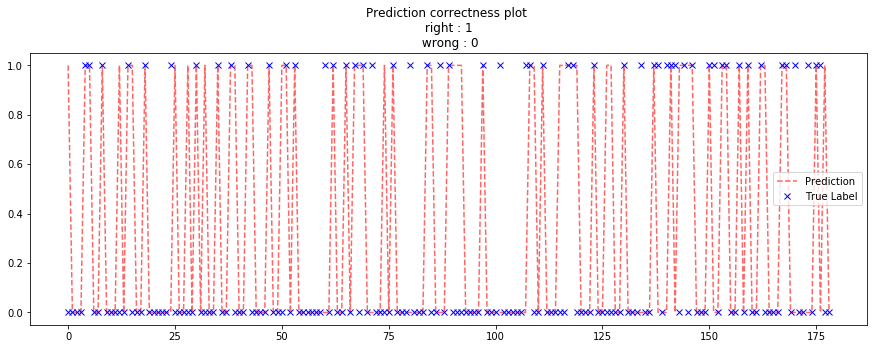

In [7]:
from matplotlib import pyplot as plt
#plt.plot(result_log[['right','wrong']])
fig=plt.figure(figsize=(15,5))
plt.plot(result_log['True Label'],'r--',alpha=0.6)
plt.plot(result_log['Predictions'],'bx')
plt.legend(['Prediction','True Label'])
plt.title('Prediction correctness plot \n right : 1 \n wrong : 0')
plt.show()

In [8]:
print('Press Enter for reduced error pruning')
accuracy=0
max_i=0
max_acc=0
best_summary = summary
accs=[]
vbs=True
for i in range(len(summary)):
        temp_rule=summary[i]
        if (len(summary[i])>4):
            temp=summary[i][-2:]
            summary[i]=summary[i][:-4]
            summary[i]=summary[i]+temp
        #print(summary[i])
        if accuracy>=max_acc:
            max_acc=accuracy
            best_summary=summary
            max_i=i
        if i==5: 
            vbs=False
            print('\n\n Skipping verbose output ...\n\n')
        accuracy,_=predict_all(test_df,test_target,summary,verbose=vbs)
        #print(accuracy)
        accs.append(accuracy)
        summary[i]=temp_rule
#print('summary',max_summary)

print('max_accuracy',max_acc)
#i  8
#max_accuracy 66.76300578034682


Press Enter for reduced error pruning
--------------------------------
179
0 precision 0.8695652173913043 recall 0.8
1 precision 0.609375 recall 0.7222222222222222
Summary :  correct: 139 total : 179 accuracy : 77.6536312849162 %
--------------------------------
179
0 precision 0.8724637681159421 recall 0.800531914893617
1 precision 0.609375 recall 0.7267080745341615
Summary :  correct: 140 total : 179 accuracy : 78.2122905027933 %
--------------------------------
179
0 precision 0.8673913043478261 recall 0.7995991983967936
1 precision 0.609375 recall 0.7188940092165899
Summary :  correct: 137 total : 179 accuracy : 76.53631284916202 %
--------------------------------
179
0 precision 0.8695652173913043 recall 0.8
1 precision 0.609375 recall 0.7222222222222222
Summary :  correct: 140 total : 179 accuracy : 78.2122905027933 %
--------------------------------
179
0 precision 0.8695652173913043 recall 0.8
1 precision 0.609375 recall 0.7222222222222222
Summary :  correct: 139 total : 179 ac

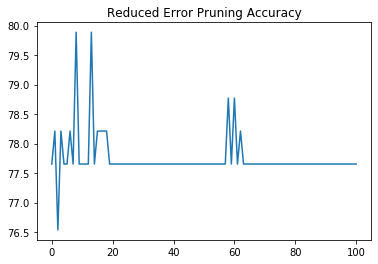

In [9]:
from matplotlib import pyplot as plt
plt.plot(np.array(accs))
plt.title('Reduced Error Pruning Accuracy')
plt.show()

In [10]:
for node in best_summary:
    for i,edge in enumerate(node):
        if i%2==0:
            print(edge,end='  ->')
        else: print(edge,end=' ')
    print('')

Sex  ->male Pclass  ->3 SibSp  ->1 Embarked  ->S Age  ->Age>=6.0 Fare  ->Fare<10.5 Parch  ->0 Survived  ->0 
Sex  ->male Pclass  ->3 SibSp  ->1 Embarked  ->S Age  ->Age>=6.0 Fare  ->Fare>=10.5 Parch  ->5 Survived  ->0 
Sex  ->male Pclass  ->3 SibSp  ->1 Embarked  ->S Age  ->Age<6.0 Survived  ->1 
Sex  ->male Pclass  ->3 SibSp  ->1 Embarked  ->Q Survived  ->0 
Sex  ->male Pclass  ->3 SibSp  ->1 Embarked  ->C Fare  ->Fare>=10.5 Parch  ->1 Survived  ->1 
Sex  ->male Pclass  ->3 SibSp  ->1 Parch  ->0 Age  ->Age>=6.0 Survived  ->0 
Sex  ->male Pclass  ->3 SibSp  ->1 Fare  ->Fare<10.5 Survived  ->0 
Sex  ->male Pclass  ->3 SibSp  ->0 Fare  ->Fare<10.5 Embarked  ->S Parch  ->0 Age  ->Age>=6.0 Survived  ->0 
Sex  ->male Pclass  ->3 Parch  ->1 Survived  ->0 
Sex  ->male Pclass  ->3 Embarked  ->Q Age  ->Age>=6.0 Parch  ->0 Survived  ->0 
Sex  ->male Pclass  ->3 Embarked  ->C Age  ->Age>=6.0 Parch  ->0 Survived  ->0 
Sex  ->male Pclass  ->3 Fare  ->Fare>=10.5 Parch  ->0 Embarked  ->S Age  ->Age>=